## Travelling Salesman problem

In [25]:
%matplotlib widget
from IPython.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

In [26]:
!pip install dwave-ocean-sdk

In [106]:
pip install --upgrade dwave-system dwave-ocean-sdk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 2.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 4.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: dimod
    Found existing installation: dimod 0.12.14
    Uninstalling dimod-0.12.14:
      Successfully uninstalled dimod-0.12.14
  Attempting uninstall: dwave-networkx
    Found existing installation: dwave-networkx 0.8.14
    Uninstalling dwave-networkx-0.8.14:
      Successfully uninstalled dwave-networkx-0.8.14
  Attempting uninstall: minorminer
    Found existing installation: minorminer 0.2.13
    Uninstalling minorminer-0.2.13:
      Successfully unins

In [107]:
!pip install dimod dwave-system

In [39]:
from IPython.display import display, HTML
from dimod import BinaryQuadraticModel
from dwave.system import DWaveSampler, EmbeddingComposite
from dwave.system import LeapHybridSampler
import random
import numpy as np
import os
import itertools
import time

os.environ['DWAVE_API_TOKEN'] = 'DEV-59bd53c8bc68d61ddeae31437faea28675837626'


random.seed(42)
cities = ["Munich", "Hamburg", "Stuttgart", "Berlin", "Frankfurt", "Paris", "Madrid", "Barcelona", "Tenerife", "Malaga", "Valencia", "Sevilla", "Lisboa", "Roma"]
n = len(cities)
A = 100
B = 100
C = 1
distances = {}
for cindex1 in range(len(cities)-1):
    c1 = cities[cindex1]
    for cindex2 in range(cindex1+1,len(cities)):
        c2 = cities[cindex2]
        distances[c1,c2] = random.randint(1,6)
        distances[c2,c1] = distances[c1,c2]


print(distances)

distance_matrix = np.zeros((n, n), dtype=int)
for (c1, c2), dist in distances.items():
    i, j = cities.index(c1), cities.index(c2)
    distance_matrix[i, j] = distance_matrix[j, i] = dist

print("Distance Matrix:")
print(distance_matrix)


{('Munich', 'Hamburg'): 6, ('Hamburg', 'Munich'): 6, ('Munich', 'Stuttgart'): 1, ('Stuttgart', 'Munich'): 1, ('Munich', 'Berlin'): 1, ('Berlin', 'Munich'): 1, ('Munich', 'Frankfurt'): 6, ('Frankfurt', 'Munich'): 6, ('Munich', 'Paris'): 3, ('Paris', 'Munich'): 3, ('Munich', 'Madrid'): 2, ('Madrid', 'Munich'): 2, ('Munich', 'Barcelona'): 2, ('Barcelona', 'Munich'): 2, ('Munich', 'Tenerife'): 2, ('Tenerife', 'Munich'): 2, ('Munich', 'Malaga'): 6, ('Malaga', 'Munich'): 6, ('Munich', 'Valencia'): 1, ('Valencia', 'Munich'): 1, ('Munich', 'Sevilla'): 6, ('Sevilla', 'Munich'): 6, ('Munich', 'Lisboa'): 6, ('Lisboa', 'Munich'): 6, ('Munich', 'Roma'): 5, ('Roma', 'Munich'): 5, ('Hamburg', 'Stuttgart'): 1, ('Stuttgart', 'Hamburg'): 1, ('Hamburg', 'Berlin'): 5, ('Berlin', 'Hamburg'): 5, ('Hamburg', 'Frankfurt'): 4, ('Frankfurt', 'Hamburg'): 4, ('Hamburg', 'Paris'): 1, ('Paris', 'Hamburg'): 1, ('Hamburg', 'Madrid'): 1, ('Madrid', 'Hamburg'): 1, ('Hamburg', 'Barcelona'): 1, ('Barcelona', 'Hamburg'): 

### Creates the QUBO model

In [40]:
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite
N = len(cities)
T = N
Q = {}

# Restricción: cada ciudad debe ser visitada exactamente una vez
for c in range(n):
    for t1 in range(n):
        for t2 in range(n):
            if t1 != t2:
                Q[((t1, c), (t2, c))] = Q.get(((t1, c), (t2, c)), 0) + 2 * A
            else:
                Q[((t1, c), (t1, c))] = Q.get(((t1, c), (t1, c)), 0) - 2 * A
        Q[((t1, c), (t1, c))] = Q.get(((t1, c), (t1, c)), 0) + A

# Restricción: cada tiempo debe tener exactamente una ciudad
for t in range(n):
    for c1 in range(n):
        for c2 in range(n):
            if c1 != c2:
                Q[((t, c1), (t, c2))] = Q.get(((t, c1), (t, c2)), 0) + 2 * B
            else:
                Q[((t, c1), (t, c1))] = Q.get(((t, c1), (t, c1)), 0) - 2 * B
        Q[((t, c1), (t, c1))] = Q.get(((t, c1), (t, c1)), 0) + B

# Función objetivo: minimizar la distancia total recorrida
for t in range(n-1):
    for c1 in range(n):
        for c2 in range(n):
            if c1 != c2:
                Q[((t, c1), (t+1, c2))] = Q.get(((t, c1), (t+1, c2)), 0) + C * distance_matrix[c1, c2]


### Find the minima using QUBO Solver CPU

In [42]:

import psutil
import datetime as dt
import time
#from dwave.system import DWaveSampler, EmbeddingComposite
# Resolver el QUBO utilizando el sampler híbrido de D-Wave
# Convertir el problema QUBO a un objeto BinaryQuadraticModel
# Convertir el problema QUBO a un objeto BinaryQuadraticModel
def calculate_total_service_time(solution):
    total_service_time = 0
    for key, value in solution.items():
        # Aquí debes interpretar cada variable de la solución según tu formulación
        # y calcular el tiempo total del servicio sin tener en cuenta la latencia
        # Ejemplo hipotético:
        # total_service_time += value * tiempo_correspondiente[key]
        pass  # Ajusta según tu formulación
    return total_service_time
def get_memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024  # Convertir a MB

bqm = BinaryQuadraticModel.from_qubo(Q)
start_time = time.time()
initial_memory = get_memory_usage()

# Resolver el problema utilizando el sampler D-Wave
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample(bqm, num_reads=1000)
print(sampleset.info)

# Obtener la mejor solución
solution = sampleset.first.sample
end_time = time.time()
final_memory = get_memory_usage()

# Interpretar la solución
route = [-1] * n
for (t, c) in solution:
    if solution[(t, c)] == 1:
        route[t] = c
total_distance = 0
for i in range(n-1):
    total_distance += distance_matrix[route[i], route[i+1]]
total_distance += distance_matrix[route[-1], route[0]]  # Volver a la ciudad de inicio

num_qubits_used = len(sampleset.variables)
total_service_time = calculate_total_service_time(solution)

# Mostrar resultados
execution_time = end_time - start_time
print("La ruta óptima es:", [cities[i] for i in route])
print("Distancia total recorrida:", total_distance)
print("Tiempo de ejecución:", execution_time, "segundos")
print("Uso de memoria inicial:", initial_memory, "MB")
print("Uso de memoria final:", final_memory, "MB")
print("Incremento de uso de memoria:", final_memory - initial_memory, "MB")
print("Número de qubits utilizados:", num_qubits_used)
print("Tiempo total del servicio (sin latencia):", total_service_time)

# Construir la matriz resultado para visualizar la ruta
result = np.zeros((n, n), dtype=object)
for (t, c) in solution:
    if solution[(t, c)] == 1:
        result[t, c] = cities[c]
    else:
        result[t, c] = 0

print("CPU Solver Formatted Result:")
for row in result:
    print(row)


{'timing': {'qpu_sampling_time': 275500.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 234.92, 'qpu_access_time': 291269.16, 'qpu_access_overhead_time': 7867.84, 'qpu_programming_time': 15769.16, 'qpu_delay_time_per_sample': 20.58, 'post_processing_overhead_time': 34.0, 'total_post_processing_time': 34.0}, 'problem_id': '931d3a2a-461b-4a21-ae15-1c1627d14df1'}
La ruta óptima es: ['Barcelona', 'Hamburg', 'Roma', 'Sevilla', 'Roma', 'Madrid', 'Roma', 'Paris', 'Tenerife', 'Roma', 'Malaga', 'Berlin', 'Frankfurt', 'Roma']
Distancia total recorrida: 49
Tiempo de ejecución: 154.16072607040405 segundos
Uso de memoria inicial: 38.55859375 MB
Uso de memoria final: 223.140625 MB
Incremento de uso de memoria: 184.58203125 MB
Número de qubits utilizados: 196
Tiempo total del servicio (sin latencia): 0
CPU Solver Formatted Result:
[0 0 0 0 0 0 0 'Barcelona' 0 0 0 0 0 0]
[0 'Hamburg' 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 'Sevilla' 0 0]
[0 0

### Draw Solution

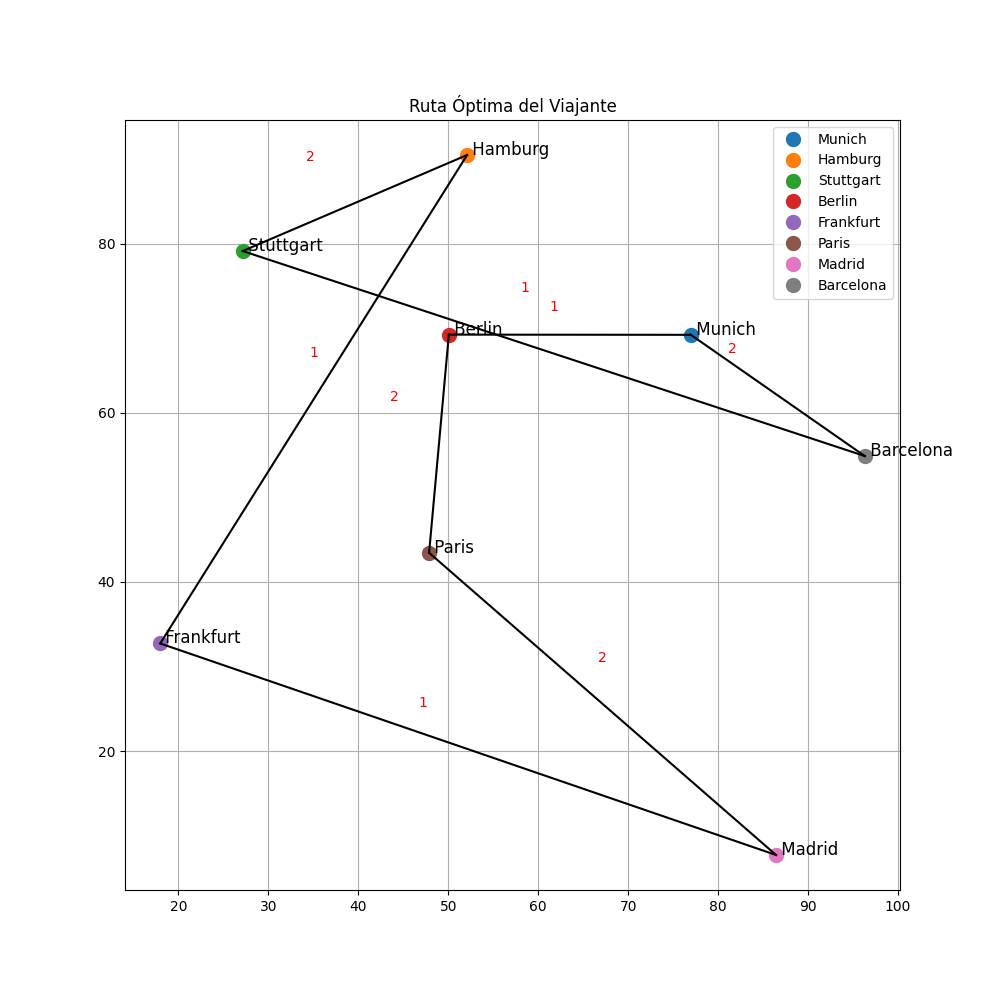

In [89]:
import matplotlib.pyplot as plt

# Función para visualizar la ruta y las distancias entre ciudades
def plot_route(route, cities, distance_matrix):
    plt.figure(figsize=(10, 10))  # Aumentar el tamaño del gráfico
    ax = plt.gca()

    # Coordenadas de las ciudades (para visualización)
    coords = np.random.rand(n, 2) * 100  # Coordenadas aleatorias en un plano 100x100
    for i, (x, y) in enumerate(coords):
        ax.plot(x, y, 'o', markersize=10, label=cities[i])
        ax.text(x, y, f' {cities[i]}', fontsize=12)

    # Dibujar la ruta y añadir las distancias
    for i in range(n):
        start_city = route[i]
        end_city = route[(i + 1) % n]
        start_coord = coords[start_city]
        end_coord = coords[end_city]
        ax.plot([start_coord[0], end_coord[0]], [start_coord[1], end_coord[1]], 'k-')
        
        # Calcular el punto medio para poner la etiqueta de la distancia
        mid_point = (start_coord + end_coord) / 2
        distance = distance_matrix[start_city, end_city]
        
        # Ajustar posición de la etiqueta para que no se solape
        label_offset = np.array([0, 5])  # Ajuste vertical
        if start_coord[0] > end_coord[0]:
            label_offset[0] = -5  # Ajuste horizontal si necesario
        ax.text(mid_point[0] + label_offset[0], mid_point[1] + label_offset[1], 
                f'{distance}', color='red', fontsize=10, ha='center')

    plt.title("Ruta Óptima del Viajante")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para dibujar la ruta con distancias
plot_route(route, cities, distance_matrix)
